<a href="https://colab.research.google.com/github/vlad-danaila/machine-learning-workout/blob/master/Pytorch_Workout_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MNIST Classification**

In [1]:
!pip3 install torch torchvision

In [0]:
import torch as t
import numpy as np
import sklearn as sk
import torchvision as tv
import matplotlib.pyplot as plt

**Load Data**

In [0]:
transforms = tv.transforms.Compose([
   tv.transforms.Resize((20, 20)),
   tv.transforms.ToTensor()
   # 0 mean and 1 variance leaves dataset unaltered, included just for learning purposes
   # tv.transforms.Normalize((0,), (1,))  
])

batch_size = 32

dataset_train = tv.datasets.MNIST(root = '.', train = True, download = True, transform = transforms)
dataset_valid = tv.datasets.MNIST(root = '.', train = False, download = True, transform = transforms)

loader_train = t.utils.data.DataLoader(dataset_train, batch_size = batch_size)
loader_valid = t.utils.data.DataLoader(dataset_valid, batch_size = batch_size, shuffle = False)

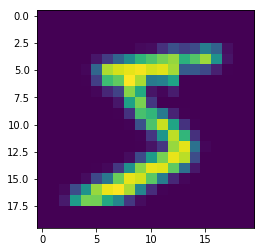

In [4]:
img, label = next(iter(loader_train))

def plot_img(img):
  img = img.clone().detach().numpy()
  img = img.reshape(*img.shape[1:])
  # clipping not needed, just for learning purpose
  # img = img.clip(0, 1)
  plt.imshow(img)
  
plot_img(img[0])

**Define Model**

In [0]:
class Classifier(t.nn.Module):
  
  def __init__(self, in_size, h1_size, h2_size, out_size):
    super().__init__()
    self.h1 = t.nn.Linear(in_size, h1_size)
    self.h2 = t.nn.Linear(h1_size, h2_size)
    self.out = t.nn.Linear(h2_size, out_size)
    
  def forward(self, x):
    x = t.nn.functional.relu(self.h1(x))
    x = t.nn.functional.relu(self.h2(x))
    x = self.out(x)
    return x

**Training**

In [6]:
epochs = 2
dimensions = 400, 100, 50, 10
model = Classifier(*dimensions)
model = model.cuda()
val_losses = []
train_losses = []
val_accuracy = []
train_accuracy = []
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr = 0.001)

def accuracy(x, y, y_pred):
    max_values, max_indices = t.max(y_pred, 1)
    accuracy = max_indices == y
    accuracy = accuracy.cpu().numpy()
    return np.sum(accuracy) / len(accuracy)
    
def train_model():
    for x, y in loader_train:
      x, y = x.cuda(), y.cuda()
      x = x.reshape(-1, dimensions[0])
      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      train_losses.append(loss.cpu().detach().numpy())
      train_accuracy.append(accuracy(x, y, y_pred))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

def validate_model():
    epoch_loss = 0
    epoch_accuracy = 0
    dataset_len = len(loader_valid)
  
    with t.no_grad():
      for x, y in loader_valid:
        x, y = x.cuda(), y.cuda()
        x = x.reshape(-1, dimensions[0])
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        epoch_loss += loss       
        epoch_accuracy += accuracy(x, y, y_pred)
      
    val_losses.append((epoch_loss / dataset_len).cpu().numpy())
    val_accuracy.append(epoch_accuracy / dataset_len)
    
validate_model()
for i in range(epochs):
  train_model()
  validate_model()
  print('Done epoch', i + 1)

  


Done epoch 1
Done epoch 2


**Plot Training**

Text(0, 0.5, 'Loss')

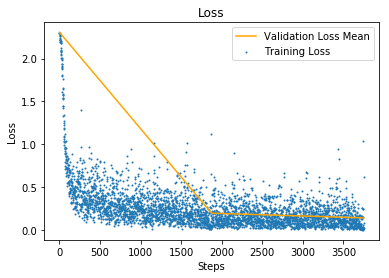

In [7]:
dataset_len = len(train_losses)
val_steps = dataset_len // epochs
val_moments = list(range(0, dataset_len + val_steps, val_steps))

plt.scatter(range(dataset_len), train_losses, s = 1, label = 'Training Loss')
plt.plot(val_moments, val_losses, label = 'Validation Loss Mean', color = 'orange')
plt.legend()
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')

Validation accuracy is: 0.9562699680511182


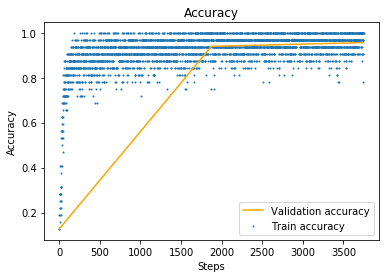

In [8]:
plt.scatter(range(len(train_accuracy)), train_accuracy, s = 1, label = 'Train accuracy')
plt.plot(val_moments, val_accuracy, color = 'orange', label = 'Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Accuracy')

print('Validation accuracy is:', val_accuracy[-1])